In [1]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython import display as disp

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 25  # videos can take a very long time to render so only do it every N episodes

env = gym.make("BipedalWalker-v3")
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

/opt/homebrew/lib/python3.9/site-packages/gym/wrappers/monitor.py:31: UserWarning: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  warnings.warn(


In [2]:
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

capacity = 2e6
gamma = 0.99
batch_size = 64 # 128 for hardcore
policy_noise = 0.2
noise_clip = 0.5
policy_freq = 2
tau = 0.005
lr = 5e-4
max_episodes = 1000 # 2000 for hardcore
max_timesteps = 2000

In [3]:
class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action, net_width=256):
		super(Actor, self).__init__()
		self.max_action = max_action

		self.l1 = nn.Linear(state_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, action_dim)		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return torch.tanh(self.l3(a)) * self.max_action

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, net_width=256):
        super(Critic, self).__init__()
		# Q1
        self.l1 = nn.Linear(state_dim + action_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, 1)

		# Q2
        self.l4 = nn.Linear(state_dim + action_dim, net_width)
        self.l5 = nn.Linear(net_width, net_width)
        self.l6 = nn.Linear(net_width, 1)

    def Q1(self, state, action):
        # Q1
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

    def forward(self, state, action):
        # Q1 and Q2
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

In [5]:
class ReplayBuffer(object):
    '''
    Based on: https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    '''
    def __init__(self, max_size=2e5):
        self._storage = []
        self._maxsize = max_size
        self._next_idx = 0

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(np.array(reward, copy=False))
            next_states.append(np.array(next_state, copy=False))
            dones.append(np.array(done, copy=False))
        return np.array(states), np.array(actions), np.array(rewards).reshape(-1, 1), np.array(next_states), np.array(dones).reshape(-1, 1)


In [6]:
class Agent():
    def __init__(self):
        self.actor_1 = Actor(obs_dim, act_dim, max_action, 256).to(device)
        self.actor_2 = Actor(obs_dim, act_dim, max_action, 256).to(device)

        self.actor_target_1 = Actor(obs_dim, act_dim, max_action, 256).to(device)
        self.actor_target_2 = Actor(obs_dim, act_dim, max_action, 256).to(device)
        self.actor_target_1.load_state_dict(self.actor_1.state_dict())
        self.actor_target_2.load_state_dict(self.actor_2.state_dict())
        
        self.actor_optimizer_1 = torch.optim.Adam(self.actor_1.parameters(), lr=lr)
        self.actor_optimizer_2 = torch.optim.Adam(self.actor_2.parameters(), lr=lr)

        self.critic = Critic(obs_dim, act_dim, 256).to(device)

        self.critic_target = Critic(obs_dim, act_dim, 256).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr)

        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action_1 = self.actor_1(state).cpu().data.numpy().flatten()
        action_2 = self.actor_2(state).cpu().data.numpy().flatten()
        action_1 = (action_1 + np.random.normal(0, 0.1, size=act_dim)).clip(-max_action, max_action)
        action_2 = (action_2 + np.random.normal(0, 0.1, size=act_dim)).clip(-max_action, max_action)
        q_1_1, q_1_2 = self.critic(state, torch.FloatTensor(action_1.reshape(1, -1)).to(device))
        q_1 = torch.max(q_1_1, q_1_2).mean()
        q_2_1, q_2_2 = self.critic(state, torch.FloatTensor(action_2.reshape(1, -1)).to(device))
        q_2 = torch.max(q_2_1, q_2_2).mean()
        if q_1 > q_2:
            return action_1
        else:
            return action_2

    def train(self, replay_buffer, iterations):
        for it in range(iterations):
            state, action, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            reward = torch.FloatTensor(reward).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).to(device)
            
            with torch.no_grad():
                noise = torch.randn_like(action).data.normal_(0, policy_noise).to(device)
                noise = noise.clamp(-noise_clip, noise_clip)
                next_action_1 = (self.actor_target_1(next_state) + noise).clamp(-self.max_action, self.max_action)
                noise = torch.randn_like(action).data.normal_(0, policy_noise).to(device)
                noise = noise.clamp(-noise_clip, noise_clip)
                next_action_2 = (self.actor_target_2(next_state) + noise).clamp(-self.max_action, self.max_action)

            next_action_1_q_1, next_action_1_q_2 = self.critic(next_state, next_action_1)
            next_action_1_q = torch.max(next_action_1_q_1, next_action_1_q_2).mean()
            next_action_2_q_1, next_action_2_q_2 = self.critic(next_state, next_action_2)
            next_action_2_q = torch.max(next_action_2_q_1, next_action_2_q_2).mean()

            #  maximizeze Qφ(s, a˜)
            if next_action_1_q > next_action_2_q:
                next_action = next_action_1
            else:
                next_action = next_action_2

            #  estimate the target Q-value
            target_q1, target_q2 = self.critic_target(next_state, next_action)
            #  Select the minimum of the two Q-values to calculate the target value
            target_q = torch.min(target_q1, target_q2)
            target_q = reward + ((1.0 - done) * gamma * target_q).detach()
            # Estimate the Q- value for the state-action pair (s, a), QφC1(s, a) and QφC2(s, a)
            current_q1, current_q2 = self.critic(state, action)
            critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

            '''
            Update Q-value by backpropogating the loss 
            update the critic network parameters the stochastic gradient descent.
            '''
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            if it % policy_freq == 0:

                actor_1_loss = -self.critic.Q1(state, self.actor_1(state)).mean()
                actor_2_loss = -self.critic.Q1(state, self.actor_2(state)).mean()

                '''
                Update the actor networks A1 and A2 by doing gradient ascent 
                on the Q-value of a critic network, 
                ∇φAi QφC1(s, µφAi (s)), i = 1, 2
                '''
                self.actor_optimizer_1.zero_grad()
                actor_1_loss.backward()
                self.actor_optimizer_1.step()

                self.actor_optimizer_2.zero_grad()
                actor_2_loss.backward()
                self.actor_optimizer_2.step()

                # Update the weights of the critic target and actor target networks.
                for param, target_param in zip(self.actor_1.parameters(), self.actor_target_1.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                
                for param, target_param in zip(self.actor_2.parameters(), self.actor_target_2.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

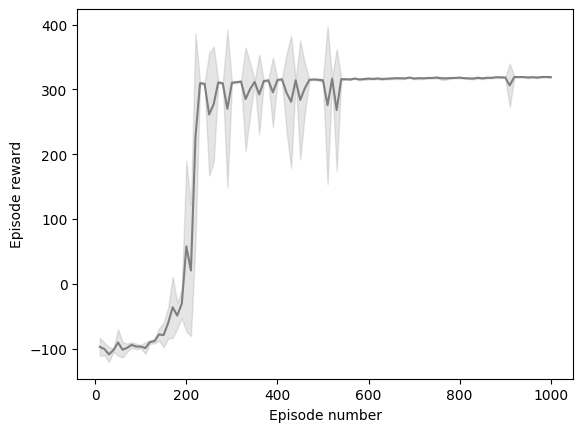

In [7]:
# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")

# initialise agent
agent = Agent()
replay_buffer = ReplayBuffer(capacity)

for episode in range(1, max_episodes+1):
    state = env.reset()
    tmp_buffer = []
    for t in range(max_timesteps):
        if episode < 20:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)
            # add noise to action
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        # decrease fall down reward 
        if reward == -100:
            fall_down = True
            reward = -5
        else:
            fall_down = False
            reward = reward * 5
        # store data in replay buffer
        replay_buffer.add(state, action, reward, next_state, done)

        if episode > 20:
            agent.train(replay_buffer, 1)

        state = next_state

        if done or t == max_timesteps - 1: 
            if episode < 20:
                break
            agent.train(replay_buffer, t)
            
            if len(reward_list) > 0 and np.mean(reward_list[-50:]) > 250:
                for param in agent.critic_optimizer.param_groups:
                    param['lr'] = 5e-4 - (5e-4 - 5e-5) * episode / max_episodes
                for param in agent.actor_optimizer_1.param_groups:
                    param['lr'] = 5e-4 - (5e-4 - 5e-5) * episode / max_episodes
                for param in agent.actor_optimizer_2.param_groups:
                    param['lr'] = 5e-4 - (5e-4 - 5e-5) * episode / max_episodes
            break
    # append the episode reward to the reward list
    reward_list.append(ep_reward)

    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0
    
    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
            # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)
